In [1]:
# load modules and data
import inspect
from rich.console import Console
from rich.syntax import Syntax
from pqdm.processes import pqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from whygreedy import *

# set up plotting env
sns.set_theme(style="whitegrid", palette="pastel")
plt.rcParams.update({'font.size': 14})
console = Console(width=120)

In [2]:
# Lazy and diligent greedy
# different implementations of the greedy algorithm
# from [Twyman2022](https://pubs.acs.org/doi/10.1021/acs.chemmater.1c02644).
# These implementations can be found at `whygreedy.algo`.

# We start with the ranking parameter definition.
# printout source with python syntax
syntax = Syntax(inspect.getsource(calculate_ranking_parameter), "python")
console.print(syntax)

def calculate_ranking_parameter(product: Compound, reactant: Compound, for_oxide: bool) -> float:                       
    """                                                                                                                 
    this is the ranking parameter as defined in the paper, a smaller number indicated the oxide is more favored,        
    the one with the smallest ranking parameter will be used to "consume" the original compound                         
    """                                                                                                                 
    # if the product has an element with > 0 composition,                                                               
    # and this element is not present or is of 0 composition in the reactant,                                           
    # then the ranking parameter is inf because it is impossible to consume the reactant with this product              
    # (and x_i for this product is 0)                                                                                   
    if for_oxide:                                                                                                       
        assert "O" not in reactant.normalized_formula, "you are calculating ranking param for an oxidation reaction, " \
                                                       "but your reactant has oxygen"                                   
        check_elements = product.elements_exclude_oxygen                                                                
    else:                                                                                                               
        check_elements = product.elements                                                                               
                                                                                                                        
    for e in check_elements:                                                                                            
        product_composition = product.normalized_formula[e]                                                             
        reactant_composition = reactant.normalized_formula[e]                                                           
        if not is_close_to_zero(product_composition) and is_close_to_zero(reactant_composition):                        
            return np.inf                                                                                               
    p = 0                                                                                                               
    for element in check_elements:                                                                                      
        c = product.normalized_formula[element] / reactant.normalized_formula[element]  # the `formation cost`          
        p += c                                                                                                          
    rp = product.formation_energy_per_atom / p                                                                          
    return rp                                                                                                           
                                                                                                                        

In [3]:
# Now we implement the greedy algorithm by ourselves.
# We will use an argument `diligent_greedy` to switch between lazy and diligent versions.
syntax = Syntax(inspect.getsource(find_greedy), "python")
console.print(syntax)

def find_greedy(                                                                                                        
        reactant: Compound, products: list[Compound], first_choice: int, diligent_greedy: bool, for_oxide: bool,        
) -> Tuple[list[float], float]:                                                                                         
    if len(products) == 0:                                                                                              
        return [], - reactant.formation_energy_per_atom                                                                 
                                                                                                                        
    # placeholder for the solution                                                                                      
    solution = []                                                                                                       
    # sum of formation enthalpies of products                                                                           
    final_enthalpy = 0.0                                                                                                
                                                                                                                        
    # assign an index for oxides                                                                                        
    for iprod, prod in enumerate(products):                                                                             
        prod.properties["index"] = iprod                                                                                
                                                                                                                        
    # we will be updating the original compound, better make a deep copy                                                
    updated_reactant = deepcopy(reactant)                                                                               
    sorted_products = products  # no need for deep copy                                                                 
                                                                                                                        
    # init the loop and perform the first greedy ranking                                                                
    counter = 0                                                                                                         
    sorted_products = sorted(sorted_products,                                                                           
                             key=lambda x: calculate_ranking_parameter(x, updated_reactant, for_oxide=for_oxide))       
                                                                                                                        
    while len(solution) < len(products):                                                                                
        if diligent_greedy:                                                                                             
            # greedy means to find the best in each iteration                                                           
            # the implementation found on [zenodo](https://zenodo.org/record/5110202#.YlJgpsjMJyg) does not sort the    
            # product list at every iteration (only at initialization),                                                 
            # so strictly speaking it is not a greedy algorithm                                                         
            # this becomes even more problematic considering they exhausted all possible `first_choice`                 
            sorted_products = sorted(sorted_products,                                                                   
                                     key=lambda x: calculate_ranking_parameter(x, updated_reactant,                     
       

In [4]:
# Finally, we have the implementation we found on [zenodo](https://zenodo.org/record/5110202#.YlJgpsjMJyg).
# We wrote a wrapper `find_greedy_old` such that it works with our schema.
syntax = Syntax(inspect.getsource(find_greedy_old), "python")
console.print(syntax)

def find_greedy_old(                                                                                                    
        reactant: Compound, products: list[Compound], first_choice: int, for_oxide: bool,                               
) -> Tuple[list[float], float]:                                                                                         
    """                                                                                                                 
    This is just a wrapper for the implementation from 10.1021/acs.chemmater.1c02644                                    
    It is identical to `find_greedy` with `diligent_greedy` set to False                                                
    """                                                                                                                 
    if len(products) == 0:                                                                                              
        return [], - reactant.formation_energy_per_atom                                                                 
                                                                                                                        
    stable_products = []                                                                                                
    for iproduct, product in enumerate(products):                                                                       
        stable_product = {                                                                                              
            "nsites": 1,                                                                                                
            # have to make a copy as `find_comp` changes it                                                             
            "unit_cell_formula": {k: v for k, v in product.normalized_formula.items()},                                 
            "formation_energy_per_atom": product.formation_energy_per_atom,                                             
            "index": iproduct,                                                                                          
            "elements": product.elements,                                                                               
        }                                                                                                               
        stable_products.append(stable_product)                                                                          
    compound_unit_cell = reactant.normalized_formula                                                                    
                                                                                                                        
    if for_oxide:                                                                                                       
        solution_oxides, final_enthalpy, delta_enthalpy, _, _, _ = find_comp(stable_products, compound_unit_cell,       
                                                                             reactant.formation_energy_per_atom,        
                                                                             "Oxide", first_choice)                     
    else:                                                                                                               
        solution_oxides, final_enthalpy, delta_enthalpy, _, _, _ = find_comp(stable_products, compound_unit_cell,       
                                                                             reactant.formation_energy_per_atom, "non", 
                                                                             first_choice)                              
                                                                                                                        
    solution = [0.0, ] * len(products)                                                                                  
    for

In [5]:
# Now we have three different implementations:
# 1. `find_greedy_old` is the one by Twyman et al.
#     we found on [zenodo](https://zenodo.org/record/5110202#.YlJgpsjMJyg).
# 2. `find_greedy(diligent=False)` is the *lazy* greedy algorithm
# 3. `find_greedy(diligent=True)` is the *diligent* greedy algorithm
# we will evaluate them using randomly generated oxidation reactions.

# function to calculate data to compare old, lazy and diligent
syntax = Syntax(inspect.getsource(calculate_diligent_vs_lazy_oxidation), "python")
console.print(syntax)

def calculate_diligent_vs_lazy_oxidation(pair: list[Compound, list[Compound]]):                                         
    reactant, products = pair                                                                                           
                                                                                                                        
    sol_old, dh_old = find_greedy_old_first_choices(reactant, products, for_oxide=True)                                 
    sol_lazy, dh_lazy = find_greedy_first_choices(reactant, products, diligent_greedy=False, for_oxide=True)            
    sol_diligent, dh_diligent = find_greedy_first_choices(reactant, products, diligent_greedy=True, for_oxide=True)     
                                                                                                                        
    # check elemental conservation                                                                                      
    assert check_solution(sol_old, products, reactant)                                                                  
    assert check_solution(sol_lazy, products, reactant)                                                                 
    assert check_solution(sol_diligent, products, reactant)                                                             
                                                                                                                        
    # confirm we reproduce the old implementation                                                                       
    assert is_close_to_zero(dh_lazy - dh_old) and np.allclose(sol_lazy, sol_old)                                        
                                                                                                                        
    record = {                                                                                                          
        "reactant": reactant.mpid,                                                                                      
        "products": [p.mpid for p in products],                                                                         
        "sol_old": sol_old,                                                                                             
        "sol_lazy": sol_lazy,                                                                                           
        "sol_diligent": sol_diligent,                                                                                   
        "dh_old": dh_old,                                                                                               
        "dh_lazy": dh_lazy,                                                                                             
        "dh_diligent": dh_diligent,                                                                                     
    }                                                                                                                   
    return record                                                                                                       
                                                                                                                        

In [6]:
# generate random reactions, this should take < 30s
seed_max = 1000
random_oxidation_pairs = [gen_random_data(["A", "B", "C", "D"], 5, seed) for seed in range(seed_max)]
records_random_diligent_vs_lazy = pqdm(random_oxidation_pairs, calculate_diligent_vs_lazy_oxidation, n_jobs=8)

QUEUEING TASKS | :   0%|          | 0/1000 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1000 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
# confirm that `find_greedy_old` is identical to the *lazy* greedy algorithm using
def old_is_lazy(r:dict) -> bool:
    return is_close_to_zero(r["dh_lazy"] - r["dh_old"]) and np.allclose(r["sol_lazy"], r["sol_old"])

assert len(records_random_diligent_vs_lazy) == len(random_oxidation_pairs)
assert all(old_is_lazy(r) for r in records_random_diligent_vs_lazy)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


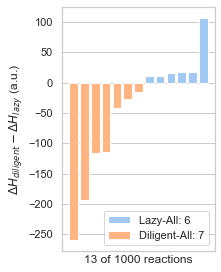

In [8]:
def nonzero_diff(records: list[dict], field1="dh_diligent", field2="dh_old"):
    diff = []
    for i, record in enumerate(records):
        dh_1 = record[field1]
        dh_2 = record[field2]
        if not is_close_to_zero(dh_1 - dh_2):
            diff.append(dh_1 - dh_2)
    return diff

def plot_diligent_vs_lazy_bar(diff, ntotal):
    fig, ax = plt.subplots(figsize=(3.3, 4))
    x_positive = []
    x_negative = []
    y_positive = []
    y_negative = []
    for x, y in zip(range(len(diff)), sorted(diff)):
        if y > 0:
            y_positive.append(y)
            x_positive.append(x)
        else:
            y_negative.append(y)
            x_negative.append(x)
    ax.bar(x_positive, y_positive, label="Lazy-All: {}".format(len(y_positive)))
    ax.bar(x_negative, y_negative, label="Diligent-All: {}".format(len(y_negative)))
    ax.set_xticks([])
    ax.set_xlabel("{} of {} reactions".format(len(diff), ntotal))
    ax.set_ylabel(r"$\Delta H_{diligent} - \Delta H_{lazy}$ (a.u.)")
    ax.legend(loc="lower right")
    return fig

diff_random_diligent_vs_lazy = nonzero_diff(records_random_diligent_vs_lazy)
fig = plot_diligent_vs_lazy_bar(diff_random_diligent_vs_lazy, len(records_random_diligent_vs_lazy))
fig.tight_layout()
fig.savefig("float/figs2_diligent_vs_lazy_random.eps")
fig.savefig("float/figs2_diligent_vs_lazy_random.tiff", bbox_inches="tight", dpi=600, pil_kwargs={"compression": "tiff_lzw"})



From randomly generated oxidation reactions it is unclear if the *diligent* version is better than the *lazy* one.
But clearly these two implementations are different.